<a href="https://colab.research.google.com/github/stephaniediamond3/DATA71200/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Load your data, including testing/training split from Project 1.

The full natality file from the CDC is massive and takes 15-30 minutes to download, so I saved the version from Project 1 that just contains the columns of interest from the dataset and the columns I created. I'm using pyarrow to read it in.

In [ ]:
!pip install gdown pyarrow

import gdown
import pandas as pd

# file URL (should be acessible to anyone with the link):
# https://drive.google.com/file/d/1rzpkN4pT8HUgLq8HaXOKBFVGXfSe9FVq/view?usp=sharing
file_id = "1rzpkN4pT8HUgLq8HaXOKBFVGXfSe9FVq"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "natality2024_trimmed_clean.parquet", quiet=False)

df = pd.read_parquet("natality2024_trimmed_clean.parquet")

Downloading...
From: https://drive.google.com/uc?id=1rzpkN4pT8HUgLq8HaXOKBFVGXfSe9FVq
To: /content/natality2024_trimmed_clean.parquet
100%|██████████| 27.0M/27.0M [00:00<00:00, 118MB/s]


### Testing/training split from Project 1:

In [ ]:
from sklearn.model_selection import train_test_split

# Prep
df_model = df.dropna(subset=["smm"]).copy()

mm_cols = ["mm_mtr","mm_plac","mm_rupt","mm_uhyst","mm_aicu"]
y = df_model["smm"]
X = df_model.drop(columns=["smm"] + mm_cols)

# Train/test split with stratification to preserve SMM balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=66, test_size=0.3, stratify=y
)

# Check shapes/balance
print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

(2538450, 29) (1087908, 29)
smm
0.0    0.984658
1.0    0.015342
Name: proportion, dtype: float64
smm
0.0    0.984658
1.0    0.015342
Name: proportion, dtype: float64


I reproduced the 70/30 stratified train/test split from Project 1 using the same random state (66). The training and testing sets have similar Severe Maternal Morbididty (SMM) prevalence (~1.5%), confirming that the split is balanced on the outcome.

### Cleaning from Project 1

I apply the same cleaning strategy as in Project 1: two risk factor variables with very high missingness (asst. reproductive technology, and fertility enhancing drugs ) are dropped, and remaining missing values (primarily in binary risk factor variables with ~0.01% missingness) are imputed using the most frequent category (mode)

In [ ]:
import numpy as np

# Drop very incomplete variables
drop_cols = ["rf_artec", "rf_fedrg"]
X_train = X_train.drop(columns=drop_cols, errors="ignore")
X_test = X_test.drop(columns=drop_cols, errors="ignore")

from sklearn.impute import SimpleImputer

#Since all vars w ~.01% missing are Y/N binaries, will impute mode
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(X_train)
X_train_new = imp_mode.transform(X_train)
X_test_new = imp_mode.transform(X_test)

X_train = pd.DataFrame(X_train_new, columns=X_train.columns)
X_test = pd.DataFrame(X_test_new, columns=X_test.columns)

X_train.isna().sum().sort_values(ascending=False).head(15)

,0
rf_pdiab,0
rf_gdiab,0
rf_phype,0
rf_ghype,0
rf_ehype,0
rf_ppterm,0
rf_inftr,0
rf_cesar,0
rf_cesarn,0
no_risks,0


# Step 2: Prepare your data

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Numeric features for Scaling
numeric_features = [
    "mager", #maternal age
    "rf_cesarn", #Number of Previous Cesareans
    "priorlive", #Prior Births Now Living
    "priordead", #Prior Births Now Dead
    "priorterm", #Prior Other Terminations
]

# Ordinal features for ordinal encoding
ordinal_features = [
    "meduc", #Mother’s Education
    "bmi_r", #Body Mass Index Recode
    "precare5", #Month Prenatal Care Began Recode
    "gestrec10", #Combined Gestation Recode 10
    "cig0_r", #Cigarettes Before Pregnancy Recode
    "dplural", #Plurality Recode (twin, triplet, etc)
]

#categorical deatures for OHE
nominal_categorical_features = [
    "pay_rec", #Payment Recode (Medicaid, Private Insurance, etc)
    "mracehisp", #Mother’s Race/Hispanic Origin
    "mhisp_r", #Mother’s Hispanic Origin Recode
    "mrace6", #Mother’s Race Recode 6
]

preprocessor = ColumnTransformer(
    transformers=[
        ("scaling", StandardScaler(), numeric_features),
        ("ordinal", OrdinalEncoder(), ordinal_features),
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), nominal_categorical_features),
    ],
    remainder="passthrough" #Already binary (risk factors, risk composite, WIC)
)


To prepare my variables for machine learning, I converted all predictors into appropriate numeric, ordinal, or one-hot encoded forms based on their underlying structure. I grouped each feature by type and applied the corresponding transformation using a ColumnTransformer.

*   I standardize the numeric features (maternal age, number of previous cesareans, and the counts of prior live births, prior deaths, and prior terminations) with StandardScaler so they share a comparable scale.
*   I encode the ordinal categorical features (maternal education, BMI category, month prenatal care began, gestational age category, cigarette use before pregnancy, and plurality) with OrdinalEncoder. These variables follow a meaningful order, so I preserve their rank structure.
*   I one-hot encode the nominal categorical features (payment method at delivery, mother’s race/Hispanic origin, mother’s Hispanic origin recode, and the six-category maternal race recode) with OneHotEncoder. These variables represent categories without an inherent ranking, so I convert each category into its own indicator column.
*   I leave the binary variables unchanged (the individual medical risk factors, the composite “no risks” indicator, and WIC indicator). These variables already function as 0/1 categorical indicators, so they do not require further transformation.


This preprocessing setup ensures that each feature reflects its underlying structure and enters the modeling stage in a consistent format that supports the supervised learning algorithms I apply in later steps.

# Step 3: Examine target attribute

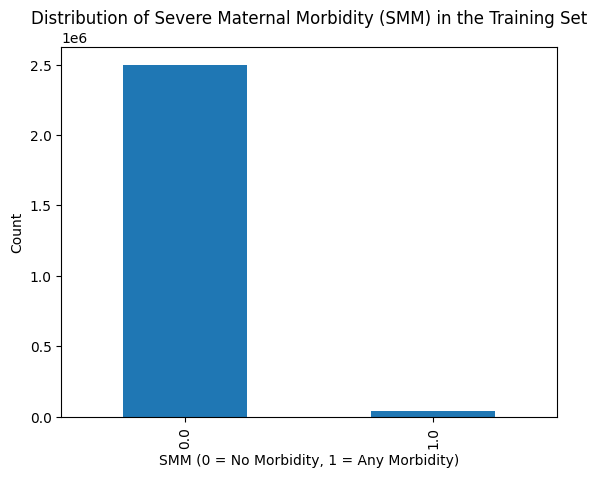

,proportion
smm,
0.0,0.984658
1.0,0.015342


In [ ]:
import matplotlib.pyplot as plt

# distribution of SMM in the training set
y_train.value_counts().plot(kind="bar")
plt.title("Distribution of Severe Maternal Morbidity (SMM) in the Training Set")
plt.xlabel("SMM (0 = No Morbidity, 1 = Any Morbidity)")
plt.ylabel("Count")
plt.show()

# proportions
y_train.value_counts(normalize=True)


SMM is a binary indicator of whether a delivery involved any severe maternal morbidity event. Because these events are uncommon in the population, I expect the positive class to be rare.

The bar plot and proportions below confirm that the training data is highly imbalanced, with a small share of deliveries coded as SMM and the majority coded as non-SMM. This distribution is not Gaussian or uniform; instead, it reflects a rare-event binary outcome.

This pattern has direct implications for model evaluation. A model could achieve high accuracy by predicting “no SMM” for every case, so accuracy alone does not provide meaningful insight. Metrics such as precision, recall, and F1 offer a more appropriate view of performance for this type of imbalanced outcome.

# Step 4: Select two supervised learning algorithms

### Algorithm 1: Linear Model (logistic regression)

I will use logistic regression because it handles imbalanced binary outcomes more effectively than other options in the first half of the list, such as K-Nearest Neighbors. Logistic regression also provides a strong baseline model that helps anchor the comparison to more flexible algorithms.

### Algorithm 2: Random Forest

I will use a Random Forest classifier because it captures nonlinear relationships, interactions, and complex patterns across maternal, demographic, and clinical predictors. Random Forests handle categorical expansions well and are generally robust to class imbalance. Comparing logistic regression to a Random Forest allows me to evaluate the trade-offs between a linear, interpretable model and a flexible ensemble method.

# Step 5: For each of the selected models

### Run with the default parameters, training on your training set and testing on your testing set. Calculate precision, recall, and F1

Logistic Regression:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# apply preprocessing from Step 2
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#fit the model
logreg = LogisticRegression(max_iter=10000).fit(X_train_processed, y_train)

print("Training set score: {:.3f}".format(logreg.score(X_train_processed, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_processed, y_test)))
print(classification_report(y_test, logreg.predict(X_test_processed),
                            target_names=["no SMM", "SMM"]))

Training set score: 0.985
Test set score: 0.985


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99   1071217
         1.0       0.00      0.00      0.00     16691

    accuracy                           0.98   1087908
   macro avg       0.49      0.50      0.50   1087908
weighted avg       0.97      0.98      0.98   1087908



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Using default settings, logistic regression predicted all births as having no maternal morbidity. Although this yields high accuracy because the outcome is rare, the model's recall for the positive class is zero. This confirms that the default model does not handle class imbalance well, which motivates the need for cross-validation and parameter tuning.

Random Forest:

In [15]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=50,
                                random_state=2,
                                n_jobs=-1)
forest.fit(X_train, y_train)

# Classification Report

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
print(classification_report(y_test, forest.predict(X_test),
                            target_names=["no SMM", "SMM"]))



Accuracy on training set: 0.992
Accuracy on test set: 0.983
              precision    recall  f1-score   support

      no SMM       0.98      1.00      0.99   1071217
         SMM       0.07      0.01      0.01     16691

    accuracy                           0.98   1087908
   macro avg       0.53      0.50      0.50   1087908
weighted avg       0.97      0.98      0.98   1087908



The default Random Forest model (50 trees) achieved very high overall accuracy (~0.98), but performance is driven entirely by the majority class. The model almost never predicts SMM cases: recall for SMM was only 0.01 and precision was 0.07. This behavior reflects the underlying class imbalance: without tuning, the Random Forest learns to return the majority class for nearly every case. Like logistic regression, the default model performs well on accuracy, but performs poorly on the minority outcome of interest.

### Run with the default parameters using cross-validation on the training set. Calculate precision, recall, and F1

Logistic Regression

In [ ]:
from sklearn.model_selection import cross_val_score

# Default logistic regression (max_iter increased only to ensure convergence)
logreg_cv = LogisticRegression(max_iter=10000)

# 5-fold cross validation on the processed training set, with a focus on minority class performance
cv_scores = cross_val_score(
    logreg_cv,
    X_train_processed,
    y_train,
    cv=5,
    scoring="f1"
)

print("cv_scores:\n{}".format(cv_scores))
print("cv_scores mean:\n{}".format(np.mean(cv_scores)))


cv_scores:
[0. 0. 0. 0. 0.]
cv_scores mean:
0.0


Using 5-fold cross-validation with default logistic regression, the F1 scores for the SMM class are 0 across all folds. This mirrors the test-set results, confirms that the default model consistently predicts only the majority class, and reinforces that I need to adjust the model to address the severe class imbalance.

Random Forest

In [16]:
#### NOTE this takes ~35 minutes to run ###
forest_cv = RandomForestClassifier(n_estimators=50, random_state=2, n_jobs=-1)

#5-fold cross validation
cv_scores_forest = cross_val_score(
    forest_cv,
    X_train,
    y_train,
    cv=5,
    scoring="f1")

print("cv_scores:\n{}".format(cv_scores_forest))
print("cv_scores mean:\n{}".format(np.mean(cv_scores_forest)))

cv_scores:
[0.01184944 0.01160497 0.00973011 0.01003032 0.01191171]
cv_scores mean:
0.01102531042703915


The 5-fold cross-validation F1 scores were all very low (~0.01), with a mean F1 of 0.011, reinforcing that the default Random Forest model does not meaningfully detect SMM cases, even when evaluated across training folds. Like the default test-set performance, the model consistently predicts the majority class and therefore produces near-zero F1 scores for the minority outcome. Cross-validation reinforces that the model is stable, but ineffective for identifying rare SMM events without tuning.

### Adjust 2-3 parameters for each model using grid search on the training set. Report evaluation metrics for the best and worst-performing parameter settings on your training set and your testing set

Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV

# base model
logreg_base = LogisticRegression(max_iter=10000)

# Hyperparameter grid:
# - C: regularization strength
# - class_weight: whether to correct for class imbalance
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "class_weight": [None, "balanced"]
}

# Grid search with 5-fold cross-validation
logreg_grid = GridSearchCV(
    estimator=logreg_base,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)


To tune the logistic regression model, I adjusted two hyperparameters that directly affect performance under extreme class imbalance:

*   C : controls model flexibility. Lower values impose stronger regularization, which can cause logistic regression to predict only the majority class.
*   class_weight: determines whether the algorithm should treat SMM and non-SMM cases as equally important. Setting "balanced" forces the model to up-weight the minority class and counter the severe imbalance in the data.


I used a grid search with 5-fold cross-validation on the training set to evaluate combinations of these parameters using F1 as the scoring metric. I used F1 because it balances precision and recall and provides a more meaningful measure of minority-class performance than accuracy; however, if I were optimizing solely for SMM detection, I would tune for recall, which prioritizes sensitivity over precision.

**Best Model**

In [ ]:

### NOTE this takes ~25 minutes to run ###

# best parameters
logreg_grid.fit(X_train_processed, y_train)

print("Best parameters:", logreg_grid.best_params_)
print("Best mean CV F1:", logreg_grid.best_score_)

# Best model (refit on full training set by GridSearchCV)
best_logreg = logreg_grid.best_estimator_

# ---- Evaluate best model on TRAINING and TEST sets ----
print("\n=== Best Logistic Regression – Training Set ===")
print(classification_report(y_train, best_logreg.predict(X_train_processed)))

print("\n=== Best Logistic Regression – Test Set ===")
print(classification_report(y_test, best_logreg.predict(X_test_processed)))



Best parameters: {'C': 0.1, 'class_weight': 'balanced'}
Best mean CV F1: 0.04438632858767309

=== Best Logistic Regression – Training Set ===
              precision    recall  f1-score   support

         0.0       0.99      0.60      0.75   2499504
         1.0       0.02      0.60      0.04     38946

    accuracy                           0.60   2538450
   macro avg       0.51      0.60      0.40   2538450
weighted avg       0.97      0.60      0.74   2538450


=== Best Logistic Regression – Test Set ===
              precision    recall  f1-score   support

         0.0       0.99      0.61      0.75   1071217
         1.0       0.02      0.60      0.04     16691

    accuracy                           0.61   1087908
   macro avg       0.51      0.60      0.40   1087908
weighted avg       0.98      0.61      0.74   1087908



**Best Parameters: (C = 0.1, class_weight = "balanced")**

This combination produced the strongest performance on the training set. Class weighting shifted the model away from majority-class dominance, and toward identifying SMM cases. The moderate regularization (C = 0.1) allowed the model to adjust without overfitting the data.

With these parameters, the model began predicting some SMM cases rather than collapsing to all zeros. Recall for SMM increased dramatically (≈ 0.60), meaning the model captured about 60% of true SMM events, as compared to 0% using the default parameters.

Precision for SMM remained low (≈ 0.02), which is expected when predicting a rare outcome. Overall accuracy fell to ~0.60, reflecting the shift toward detecting minority-class cases rather than maximizing accuracy.

This model does not produce strong clinical predictions, but it does respond meaningfully to the imbalance-aware tuning.

**Worst Model**

In [ ]:
# worst parameters
cv_results = logreg_grid.cv_results_
mean_f1 = cv_results["mean_test_score"]
worst_index = np.argmin(mean_f1)
worst_params = cv_results["params"][worst_index]

print("\nWorst parameters:", worst_params)
print("Worst mean CV F1:", mean_f1[worst_index])

# Refit a model using the worst parameters
worst_logreg = LogisticRegression(max_iter=10000, **worst_params)
worst_logreg.fit(X_train_processed, y_train)

print("\n=== Worst Logistic Regression – Training Set ===")
print(classification_report(y_train, worst_logreg.predict(X_train_processed)))

print("\n=== Worst Logistic Regression – Test Set ===")
print(classification_report(y_test, worst_logreg.predict(X_test_processed)))


Worst parameters: {'C': 0.01, 'class_weight': None}
Worst mean CV F1: 0.0

=== Worst Logistic Regression – Training Set ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99   2499504
         1.0       0.00      0.00      0.00     38946

    accuracy                           0.98   2538450
   macro avg       0.49      0.50      0.50   2538450
weighted avg       0.97      0.98      0.98   2538450


=== Worst Logistic Regression – Test Set ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99   1071217
         1.0       0.00      0.00      0.00     16691

    accuracy                           0.98   1087908
   macro avg       0.49      0.50      0.50   1087908
weighted avg       0.97      0.98      0.98   1087908



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Worst Parameters (C = 0.01, class_weight = None)**

In this model, stronger regularization (C = 0.01) and no class weighting defaulted to predicting the majority class exclusively. Without class weighting, the model is heavily biased toward predicting the majority class.

This model predicted zero SMM cases in both the training and test sets. Recall and precision for SMM fell to 0, and the F1 score remained at 0 across all folds. Accuracy stayed artificially high (~0.98) simply because almost all births do not involve SMM. However, this accuracy is not meaningful because the model is unable to detect the minority class at all.

**Model Comparison**

Parameter tuning fundamentally changed the behavior of the logistic regressions.
Adding class weights and adjusting regularization shifted the model from predicting only the majority class to identifying a meaningful proportion of SMM cases, even though precision remained low. These patterns mirror real-world challenges when modeling rare clinical outcomes and illustrate how tuning alters model behavior under severe class imbalance.

Random Forest

In [17]:
# Subsample of training data for tuning
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train,
    y_train,
    train_size=0.2,
    stratify=y_train,
    random_state=66
)

# base model
rf_base = RandomForestClassifier(random_state=2, n_jobs=-1)

#parameter grid
param_grid_rf = {
    "n_estimators": [20, 50, 100],
    "max_depth": [None, 5, 10],
    "max_features": ["sqrt", "log2"]
}

#grid search-- CV dropped to 3 for runtime concerns
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    scoring="f1",
    cv=3,      # reduce from 5 to 3 for speed
    n_jobs=-1
)

rf_grid.fit(X_train_sub, y_train_sub)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=2),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [20, 50, 100]},
             scoring='f1')

To adjust the Random Forest model, I used three parameters that directly influence model flexibility and performance:

*   n_estimators: the number of trees in the forest. While more trees stabilize predictions, they increase computation time.
*   max_depth: the maximum depth of each tree. Shallow trees reduce overfitting, while deeper trees allow the model to learn more complex patterns.
*   max_features: the number of predictors considered at each split

Due to the size of the training set, I used a stratified 20% subsample of the training data for tuning. The subsample preserves class balance and allows meaningful comparison across parameter combinations, while keeping the grid search computationally feasible in Colab. I performed a grid search with 3-fold cross-validation and used F1 score as the evaluation metric to prioritize performance on the minority SMM class.

**Best Model**

In [18]:
# extract best performing parameter combination
best_rf = rf_grid.best_estimator_

print("Best params:", rf_grid.best_params_)
print("Best CV F1:", rf_grid.best_score_)

print("\n=== Best RF – Training Set ===")
print(classification_report(y_train, best_rf.predict(X_train),
                            target_names=["no SMM", "SMM"]))

print("\n=== Best RF – Test Set ===")
print(classification_report(y_test, best_rf.predict(X_test),
                            target_names=["no SMM", "SMM"]))

Best params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 20}
Best CV F1: 0.007577080829456889

=== Best RF – Training Set ===
              precision    recall  f1-score   support

      no SMM       0.99      1.00      0.99   2499504
         SMM       0.56      0.12      0.19     38946

    accuracy                           0.99   2538450
   macro avg       0.77      0.56      0.59   2538450
weighted avg       0.98      0.99      0.98   2538450


=== Best RF – Test Set ===
              precision    recall  f1-score   support

      no SMM       0.98      1.00      0.99   1071217
         SMM       0.04      0.00      0.01     16691

    accuracy                           0.98   1087908
   macro avg       0.51      0.50      0.50   1087908
weighted avg       0.97      0.98      0.98   1087908



**Best Parameters (max_depth = None, max_features = "log2", n_estimators = 20)**

The parameter combination that performed best on the subsampled training set (F1 = 0.0076) used 20 trees, unlimited depth, and log2 feature sampling. Allowing unlimited tree depth (max_depth=None) and using log2 feature sampling increased model flexibility.

When evaluated on the full training set, the tuned model showed clear signs of overfitting: SMM recall increased to 0.12 and SMM F1 rose to 0.19, but this performance did not generalize. On the test set, SMM recall dropped to essentially zero (0.00), with precision at 0.04 and F1 at 0.01. Despite tuning, the model reverted to predicting almost exclusively the majority class.

Even under its best parameter settings, the Random Forest was unable to learn generalizable patterns for SMM prediction. Tuning increased model flexibility, but the underlying class imbalance prevented the model from capturing the rare SMM cases effectively.

**Worst Model**

In [19]:
# extract worst performing parameter combination
cv_results = rf_grid.cv_results_
mean_f1 = cv_results["mean_test_score"]
worst_idx = mean_f1.argmin()
worst_params = cv_results["params"][worst_idx]

print("Worst params:", worst_params)
print("Worst CV F1:", mean_f1[worst_idx])

# Refit worst model on full training data
rf_worst = RandomForestClassifier(
    **worst_params,
    random_state=2,
    n_jobs=-1
).fit(X_train, y_train)

print("\n=== Worst RF – Training Set ===")
print(classification_report(y_train, rf_worst.predict(X_train),
                            target_names=["no SMM", "SMM"]))

print("\n=== Worst RF – Test Set ===")
print(classification_report(y_test, rf_worst.predict(X_test),
                            target_names=["no SMM", "SMM"]))


Worst params: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 20}
Worst CV F1: 0.0

=== Worst RF – Training Set ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      no SMM       0.98      1.00      0.99   2499504
         SMM       0.00      0.00      0.00     38946

    accuracy                           0.98   2538450
   macro avg       0.49      0.50      0.50   2538450
weighted avg       0.97      0.98      0.98   2538450


=== Worst RF – Test Set ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      no SMM       0.98      1.00      0.99   1071217
         SMM       0.00      0.00      0.00     16691

    accuracy                           0.98   1087908
   macro avg       0.49      0.50      0.50   1087908
weighted avg       0.97      0.98      0.98   1087908



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Worst Parameters (max_depth = 5, max_features = "sqrt", n_estimators = 20)**

The worst-performing configuration used 20 trees with a maximum depth of 5 and sqrt feature sampling. This combination produced a cross-validated F1 score of 0.0 on the subsampled training set.

When evaluated on the full training and test sets, the model predicted only the majority class. SMM precision, recall, and F1 all dropped to 0. Overall the model reports an accuracy of approximately 0.98, but this accuracy is not meaningful because the model fails to identify any SMM cases. Restricting tree depth prevented the model from capturing even weak patterns associated with the minority class.

This configuration demonstrates how reducing model complexity can cause Random Forests to collapse entirely under severe class imbalance, defaulting to majority-class predictions and losing any ability to detect rare events.


**Model Comparison**

Across all tuned configurations, the Random Forest struggled to learn generalizable patterns for the rare SMM outcome. The best model showed modest improvement in SMM recall on the full training set, but this gain disappeared on the test set-- clear evidence of overfitting.

The worst model, with shallow trees and limited feature sampling, predicted only the majority class and returned zero recall for SMM.

Overall, tuning changed the model's behavior, but did not overcome the severe class imbalance. As with logistic regression, Random Forest performance remained dominated by the majority class, underscoring the difficulty of predicting rare clinical events without additional imbalance-handling techniques.